In [114]:
from sklearn import neighbors, metrics
import pandas as pd
from sklearn import model_selection
import keras
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve
from keras.models import Sequential
from keras.layers import Dense

Build an ANN using Keras

In [175]:
def build_model(dims, input_dim, lr=0.001, mdl=None, onehot_encode=False):
    if mdl is not None:
      return mdl
    model = Sequential()
    model.add(Dense(dims[0], input_dim=input_dim, activation='relu'))
    for dim in dims[1:]:
      model.add(Dense(dim, activation='relu'))
    final_op = 1
    activation = 'sigmoid'
    if onehot_encode:
      final_op = 2
      activation = 'softmax'
    model.add(Dense(final_op, activation=activation))
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def ann_train(dims, input_dim, X_train, y_train, lr=0.001, epochs=200, batch_size=100, verbose=False, model=None,
              callbacks=None, val_data=None, onehot_encode=False):
    from keras.wrappers.scikit_learn import KerasClassifier
    # keras_model = build_model(dims, input_dim)
    split = 0.2
    if val_data is not None:
      split = 0
    create_model = lambda: build_model(dims, input_dim, lr=lr, mdl=model, onehot_encode=onehot_encode)
    keras_model = KerasClassifier(build_fn=create_model)
    history = keras_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                              verbose=verbose, validation_split=split, callbacks=callbacks, validation_data=val_data)
    return keras_model, history


In [171]:
def get_classification_score(dt, X, y):
    return dt.score(X, y)

def get_f1_score(dt, X, y, average='macro', threshold=None):
    yp = dt.predict(X)
    return metrics.f1_score(y, yp, average=average)

## Phishing Websites dataset analysis

In [4]:
from scipy.io.arff import loadarff 

raw_data = loadarff('Training Dataset.arff')
ph_data = pd.DataFrame(raw_data[0])
ph_data.head()

for var in ph_data.columns.values:
    ph_data[var] = pd.Categorical(ph_data[var])
    ph_data[var] = ph_data[var].cat.codes

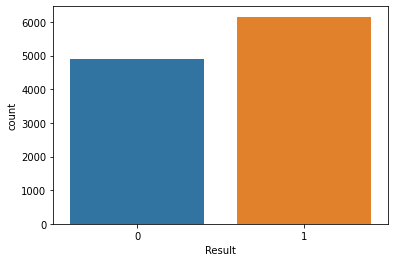

In [5]:
sns.countplot(x="Result", data=ph_data)

Now, let us analyze the impact of batch size on the training process. 


BATCH_SIZE: 100
Train Accuracy:  0.9872791767120361
Validation Accuracy:  0.9672130942344666
BATCH_SIZE: 500
Train Accuracy:  0.987561821937561
Validation Accuracy:  0.9649519324302673
BATCH_SIZE: 1000
Train Accuracy:  0.9694699645042419
Validation Accuracy:  0.9626907706260681
BATCH_SIZE: 2500
Train Accuracy:  0.9827561974525452
Validation Accuracy:  0.9615601897239685


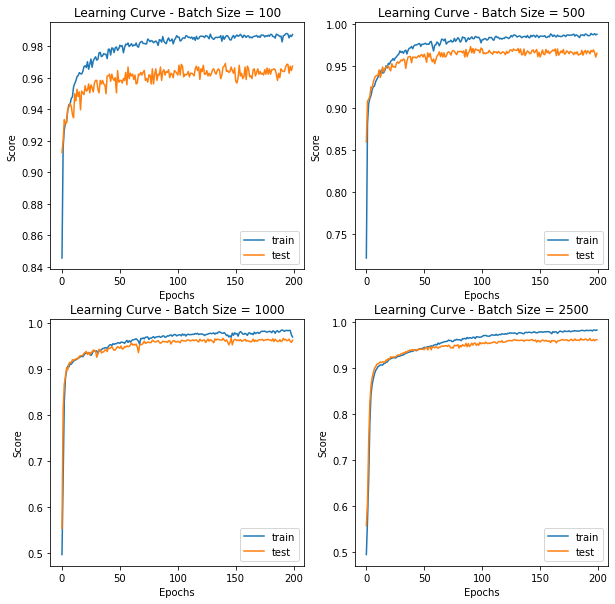

In [60]:
y = ph_data.Result.values
X = ph_data.drop(['Result'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
fig, plots = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
for i, batch_size in enumerate([100, 500, 1000, 2500]):
  ax = plots[int(i/2)][i%2]
  ax.set_title("Learning Curve - Batch Size = {}".format(batch_size))
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Score")
  print("BATCH_SIZE:", batch_size)  
  ann, history = ann_train((100, 50, 100),len(X.columns),X_train, y_train, batch_size=batch_size)
  ax.plot(history.history['accuracy'], label='train')
  ax.plot(history.history['val_accuracy'], label='test')
  ax.legend(loc="best")

  print("Train Accuracy: ", history.history['accuracy'][-1])
  print("Validation Accuracy: ", history.history['val_accuracy'][-1])


LR: 0.0001
Train Accuracy:  0.9802120327949524
Validation Accuracy:  0.9598643183708191
LR: 0.001
Train Accuracy:  0.9860070943832397
Validation Accuracy:  0.9672130942344666
LR: 0.01
Train Accuracy:  0.9830388426780701
Validation Accuracy:  0.9638213515281677
LR: 0.1
Train Accuracy:  0.9194346070289612
Validation Accuracy:  0.920293927192688
LR: 0.5
Train Accuracy:  0.550671398639679
Validation Accuracy:  0.5528547167778015
LR: 1.0
Train Accuracy:  0.5331448912620544
Validation Accuracy:  0.5528547167778015


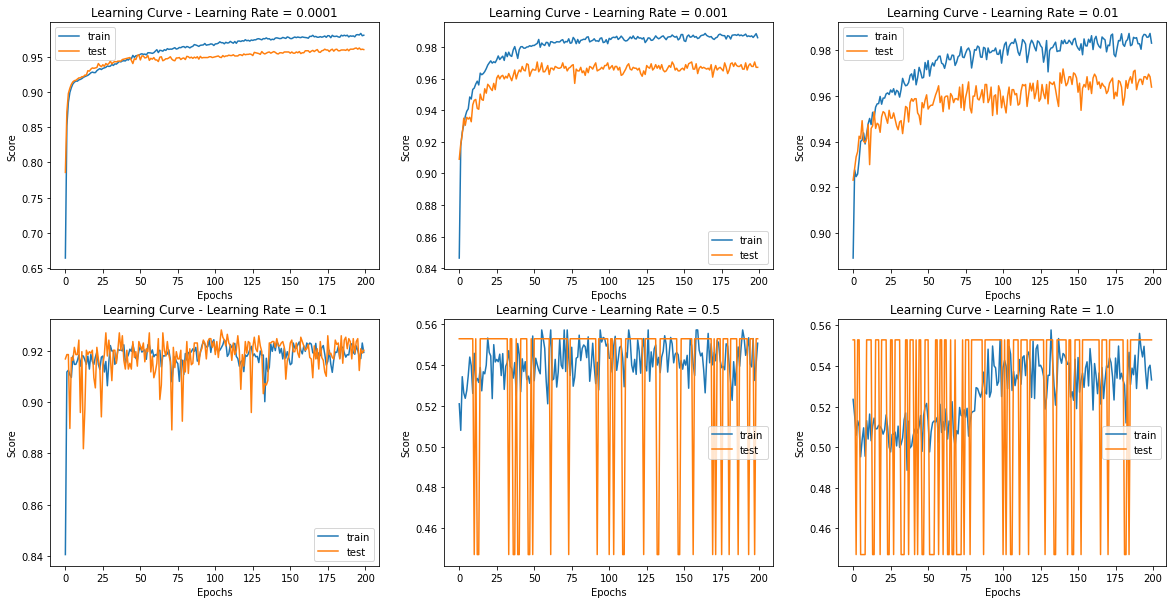

In [61]:
y = ph_data.Result.values
X = ph_data.drop(['Result'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
fig, plots = plt.subplots(nrows=2, ncols=3,figsize=(20,10))
for i, lr in enumerate([0.0001, 0.001, 0.01, 0.1, 0.5, 1.]):
  ax = plots[int(i/3)][i%3]
  ax.set_title("Learning Curve - Learning Rate = {}".format(lr))
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Score")
  print("LR:", lr)  
  ann, history = ann_train((100, 50, 100),len(X.columns),X_train, y_train, lr=lr, batch_size=100)
  ax.plot(history.history['accuracy'], label='train')
  ax.plot(history.history['val_accuracy'], label='test')
  ax.legend(loc="best")

  print("Train Accuracy: ", history.history['accuracy'][-1])
  print("Validation Accuracy: ", history.history['val_accuracy'][-1])

Train Accuracy:  0.9885512590408325
Validation Accuracy:  0.9666478037834167


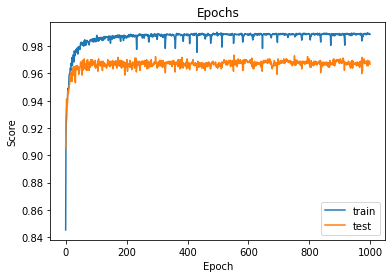

In [65]:
fig, ax = plt.subplots()
ax.set_title("Epochs")
ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ann, history = ann_train((100, 50, 100),len(X.columns),X_train, y_train, lr=0.001, batch_size=100, epochs=1000)
ax.plot(history.history['accuracy'], label='train')
ax.plot(history.history['val_accuracy'], label='test')
ax.legend(loc="best")

print("Train Accuracy: ", history.history['accuracy'][-1])
print("Validation Accuracy: ", history.history['val_accuracy'][-1])

Building the final model:


In [70]:
ann, _ = ann_train((100, 50, 100),len(X.columns),X_train, y_train, lr=0.001, batch_size=100)

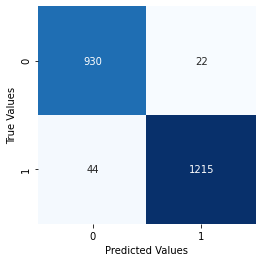

70/70 [==============================] - 0s 2ms/step - loss: 0.1328 - accuracy: 0.9701
Score: 0.9701492786407471


In [71]:
fig = plt.figure()

y_pred = ann.predict(X_test) 
mat = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(mat.T, square=True, annot=True, fmt='g', cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

print("Score:", get_classification_score(ann, X_test, y_test))

In [78]:
model_json = ann.model.to_json()
with open("model D2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
ann.model.save_weights("model D2.h5")

## Census Dataset Analysis

In [79]:
data = pd.read_csv("adult.data", sep='\t', header=None, 
                   names=["age", "workclass", "fnlwgt", "education", 
                          "education-num", "marital-status", "occupation",
                          "relationship", "race", "sex", "capital-gain", 
                          "capital-loss", "hours-per-week", "native-country", 
                          "output"])
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,output
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


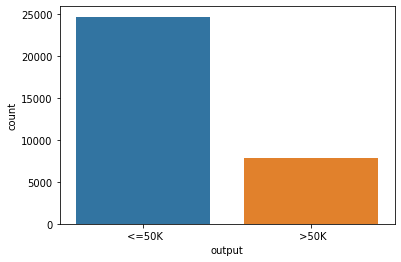

In [80]:
sns.countplot(x="output", data=data)

In [170]:
categorical_vars =["workclass", "education", "marital-status", "occupation", "relationship", 
                   "race", "sex", "native-country"]
df = data.copy()
for var in categorical_vars:
    df[var] = pd.Categorical(df[var])
    df[var] = df[var].cat.codes

continuous_vars = ["fnlwgt", "capital-gain", "capital-loss"]
for var in continuous_vars:
    df[var] = (df[var]-df[var].mean())/df[var].std()

df['fin_op'] = pd.Categorical(df['output'])
df['fin_op'] = df['fin_op'].cat.codes
y = df.fin_op.values
X = df.drop(['fin_op' ,'output'], axis=1)
from keras.utils import to_categorical
y = to_categorical(y)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,output,fin_op
0,39,7,-1.063594,9,13,4,1,1,4,1,0.148451,-0.216656,40,39,<=50K,0
1,50,6,-1.008692,9,13,2,4,0,4,1,-0.145918,-0.216656,13,39,<=50K,0
2,38,4,0.245075,11,9,0,6,1,4,1,-0.145918,-0.216656,40,39,<=50K,0
3,53,4,0.425795,1,7,2,6,0,2,1,-0.145918,-0.216656,40,39,<=50K,0
4,28,4,1.408154,9,13,2,10,5,2,0,-0.145918,-0.216656,40,5,<=50K,0


In [194]:
class Metrics(keras.callbacks.Callback):
    def __init__(self, train, valid_data):
        self.valid_data = valid_data
        self.train = train

    def on_train_begin(self, logs={}):
        self.train_f1 = []
        self.val_f1 = []

    def get_score(self, X, y):
        yp = self.model.predict(X)
        yop = np.argmax(yp, axis=1)
        yo = np.argmax(y, axis=1)
        return metrics.f1_score(yo, yop, average="macro")
    
    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.valid_data[0], self.valid_data[1]
        X_train, y_train = self.train[0], self.train[1]
        train_f1 = self.get_score(X_train, y_train)
        val_f1 = self.get_score(X_val, y_val)
        self.train_f1.append(train_f1)
        self.val_f1.append(val_f1)
        return

    def get_data(self):
        return self._data

BATCH_SIZE: 100
Train Accuracy:  0.8990786075592041
Validation Accuracy:  0.8295585513114929
BATCH_SIZE: 1000
Train Accuracy:  0.8854976296424866
Validation Accuracy:  0.834932804107666
BATCH_SIZE: 5000
Train Accuracy:  0.8586236834526062
Validation Accuracy:  0.8451055884361267
BATCH_SIZE: 10000
Train Accuracy:  0.8523370623588562
Validation Accuracy:  0.8476007580757141


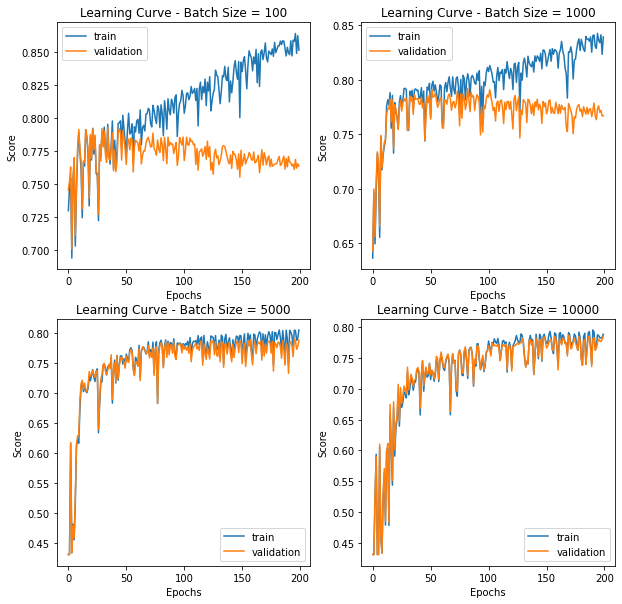

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.20, random_state=7)
fig, plots = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
for i, batch_size in enumerate([100, 1000, 5000, 10000]):
  ax = plots[int(i/2)][i%2]
  ax.set_title("Learning Curve - Batch Size = {}".format(batch_size))
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Score")
  print("BATCH_SIZE:", batch_size)  
  m = Metrics((X_t, y_t), (X_v, y_v))

  ann, history = ann_train((100, 100, 50, 50, 100),len(X.columns),X_t, y_t, 
                           batch_size=batch_size, epochs=200, callbacks=[m], val_data=(X_v, y_v), onehot_encode=True)
  ax.plot(m.train_f1, label='train')
  ax.plot(m.val_f1, label='validation')
  ax.legend(loc="best")

  print("Train Accuracy: ", history.history['accuracy'][-1])
  print("Validation Accuracy: ", history.history['val_accuracy'][-1])

LR: 0.0001
Train Accuracy:  0.8553124070167542
Validation Accuracy:  0.8437619805335999
LR: 0.001
Train Accuracy:  0.8795469999313354
Validation Accuracy:  0.8403071165084839
LR: 0.01
Train Accuracy:  0.860927164554596
Validation Accuracy:  0.8431861996650696
LR: 0.1
Train Accuracy:  0.24095402657985687
Validation Accuracy:  0.2414587289094925
LR: 0.5
Train Accuracy:  0.7590459585189819
Validation Accuracy:  0.7585412859916687
LR: 1.0
Train Accuracy:  0.7590459585189819
Validation Accuracy:  0.7585412859916687


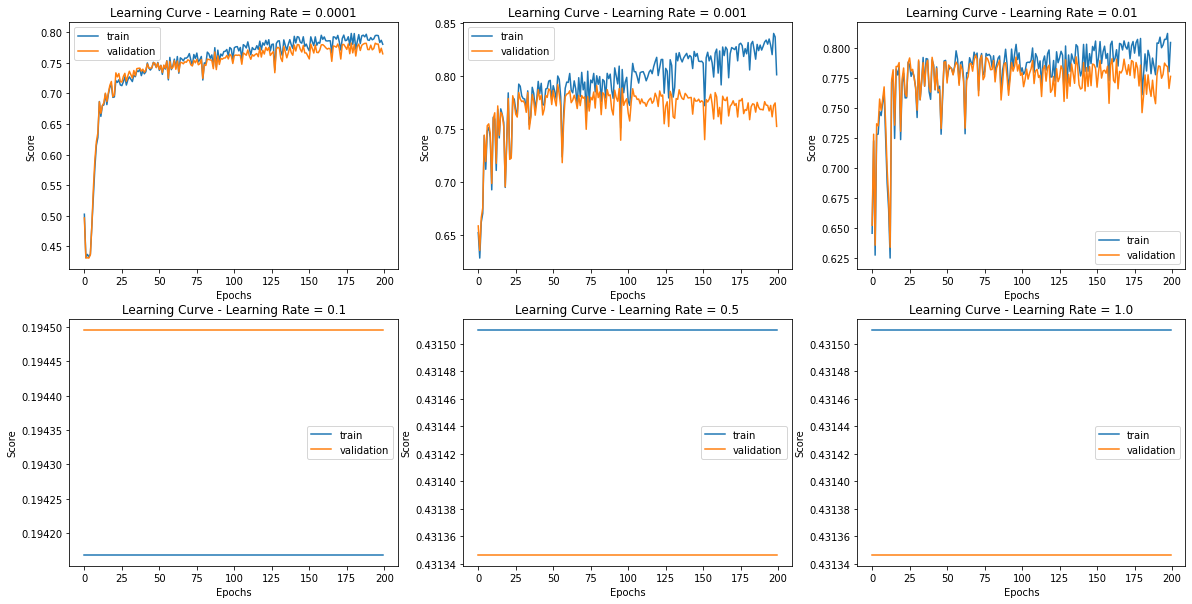

In [197]:
fig, plots = plt.subplots(nrows=2, ncols=3,figsize=(20,10))
for i, lr in enumerate([0.0001, 0.001, 0.01, 0.1, 0.5, 1.]):
  ax = plots[int(i/3)][i%3]
  ax.set_title("Learning Curve - Learning Rate = {}".format(lr))
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Score")
  print("LR:", lr)  
  m = Metrics((X_t, y_t), (X_v, y_v))

  ann, history = ann_train((100, 100, 50, 50, 100),len(X.columns),X_t, y_t, 
                           batch_size=1000, lr=lr, epochs=200, callbacks=[m], val_data=(X_v, y_v), onehot_encode=True)
  ax.plot(m.train_f1, label='train')
  ax.plot(m.val_f1, label='validation')
  ax.legend(loc="best")
  print("Train Accuracy: ", history.history['accuracy'][-1])
  print("Validation Accuracy: ", history.history['val_accuracy'][-1])

Train Accuracy:  0.8854016661643982
Validation Accuracy:  0.8358924984931946


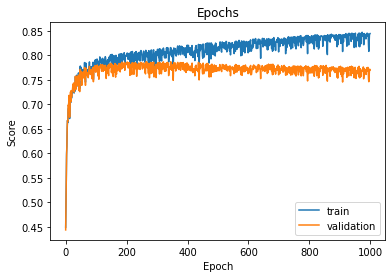

In [198]:
fig, ax = plt.subplots()
ax.set_title("Epochs")
ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ann, history = ann_train((100, 100, 50, 50, 100),len(X.columns),X_t, y_t, 
                           batch_size=1000, lr=0.0001, epochs=1000, callbacks=[m], val_data=(X_v, y_v), onehot_encode=True)

ax.plot(m.train_f1, label='train')
ax.plot(m.val_f1, label='validation')
ax.legend(loc="best")

print("Train Accuracy: ", history.history['accuracy'][-1])
print("Validation Accuracy: ", history.history['val_accuracy'][-1])

In [208]:
ann, _ = ann_train((100, 100, 50, 50, 100),len(X.columns),X_t, y_t, 
                           batch_size=1000, lr=0.0001, epochs=200, callbacks=[m], val_data=(X_v, y_v), onehot_encode=True, verbose=True)

Epoch 1/200
21/21 [==============================] - 1s 61ms/step - loss: 0.5776 - accuracy: 0.7578 - val_loss: 0.5401 - val_accuracy: 0.7585
Epoch 2/200
21/21 [==============================] - 1s 48ms/step - loss: 0.5215 - accuracy: 0.7590 - val_loss: 0.5164 - val_accuracy: 0.7585
Epoch 3/200
21/21 [==============================] - 1s 50ms/step - loss: 0.5027 - accuracy: 0.7590 - val_loss: 0.4961 - val_accuracy: 0.7589
Epoch 4/200
21/21 [==============================] - 1s 48ms/step - loss: 0.4858 - accuracy: 0.7625 - val_loss: 0.4809 - val_accuracy: 0.7691
Epoch 5/200
21/21 [==============================] - 1s 48ms/step - loss: 0.4727 - accuracy: 0.7693 - val_loss: 0.4650 - val_accuracy: 0.7741
Epoch 6/200
21/21 [==============================] - 1s 50ms/step - loss: 0.4598 - accuracy: 0.7775 - val_loss: 0.4537 - val_accuracy: 0.7837
Epoch 7/200
21/21 [==============================] - 1s 49ms/step - loss: 0.4492 - accuracy: 0.7876 - val_loss: 0.4402 - val_accuracy: 0.7944
Epoch 

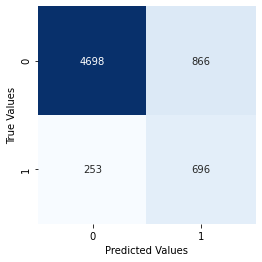

204/204 [==============================] - 1s 3ms/step - loss: 1.7339 - accuracy: 0.7852
Score: 0.7851988077163696


In [209]:
fig = plt.figure()

y_test = [np.argmax(val) for val in y_test]
mat = metrics.confusion_matrix(y_test, yp)

sns.heatmap(mat.T, square=True, annot=True, fmt='g', cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

print("Score:", get_classification_score(ann, X_test, y_test))

In [210]:
print(m.val_f1[-1])

0.7830522590047886


In [211]:
model_json = ann.model.to_json()
with open("model D1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
ann.model.save_weights("model D1.h5")